# Introduction

Hi there! This notebook will be presenting a small walkthrough in extracting the metadata of publications from the HathiTrust Digital Library as well as illustrating geographic data in Python. As an exercise, we will be examining and illustrating the publication locations of a collection of Dadaist literature extracted from HathiTrust.

[Dada](https://en.wikipedia.org/wiki/Dada), an art and literature movement which stemmed as a reaction to the physical and psychological trauma wrought by World War I, a conflict unmatched at the time in its scale, death toll, and devastation.

Below is a painting by [Max Ernst](https://en.wikipedia.org/wiki/Max_Ernst), a prominent German Dada artist.
<img src="ernst.jpg">

In [64]:
!pip install geopy
!pip install https://github.com/matplotlib/basemap/archive/v1.0.7rel.tar.gz
!pip install pyshp

    100% |████████████████████████████████| 131.5MB 4.8kB/s 
    100% |████████████████████████████████| 194kB 1.9MB/s 
  Running setup.py bdist_wheel for pyshp ... - \ done
  Stored in directory: /Users/chench/Library/Caches/pip/wheels/b8/a2/56/da058e1e1639061be3399baa32fb82362e2ae1afd8fe0179b0
Successfully built pyshp


In [5]:
import os
import numpy as np # Helps us store data in arrays
import pandas as pd # Enables us to store data in DataFrames
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Extracting the Metadata

This cell extracts all the metadata for each volume ID in paths.txt

Credit to Alex Chan for the setup cells!

In [6]:
from htrc_features import FeatureReader

with open("paths.txt", "r") as f:
    paths = [os.path.join("", line[:len(line)-1]) for line in f.readlines()]
    f.close()

dada = FeatureReader(paths)

dada.volumes() is a collection of Volume objects, each representing a unique work in our collection. Each [Volume object](http://htrc.github.io/htrc-feature-reader/htrc_features/feature_reader.m.html#htrc_features.feature_reader.Volume) has attributes we can access, such as title, author, and, importantly for our purposes, the location of publication.

In [7]:
len(dada) # The number of volumes in our collection

805

In [8]:
#This cell lets us see the first 10 titles in the collection
count = 0
collection = dada.volumes()

while (count < 10):
    item = next(collection) # Obtain the next volume in the collection
    print(item.title) # Print the volume's title
    count += 1 #  Increment count by 1

Art and archaeology.
The North American review.
The Dial
Georg Grosz; twelve reproductions from his original lithographs, with an introduction by Hi Simons.
Current opinion
The Living age ...
Century illustrated monthly magazine ...
Forum.
The weekly review.
The Chapbook.


In [9]:
# This cell prints out the publication locations of first 10 titles in the collection
count = 0
collection = dada.volumes()

while (count < 10):
    item = next(collection) # Obtain the next volume in the collection
    print(item.pub_place) # Print the volume's title
    count += 1 # Increment count by 1

nhu
iau
nyu
ilu
nyu
nyu
nyu
pau
nyu
nyu


For some cities, it is unclear what cities correspond to the abbreviations above. We need a way to map each abbreviation to a city name. 

Fortunately, we know that these abbreviations are used by the Library of Congress, so we have a way of assigning each abbreviation to its extended location name.

In [10]:
with open('marc-codes.txt', 'r') as f:
    raw = f.read()
    
marc_codes = {line.split('\t')[0]:line.split('\t')[1] for line in raw.split('\n')}
marc_codes

{'-ac': 'Ashmore and Cartier Islands',
 '-ai': 'Anguilla',
 '-air': 'Armenian S.S.R.',
 '-ajr': 'Azerbaijan S.S.R.',
 '-bwr': 'Byelorussian S.S.R.',
 '-cn': 'Canada',
 '-cp': 'Canton and Enderbury Islands',
 '-cs': 'Czechoslovakia',
 '-cz': 'Canal Zone',
 '-err': 'Estonia',
 '-ge': 'Germany (East)',
 '-gn': 'Gilbert and Ellice Islands',
 '-gsr': 'Georgian S.S.R.',
 '-hk': 'Hong Kong',
 '-iu': 'Israel-Syria Demilitarized Zones',
 '-iw': 'Israel-Jordan Demilitarized Zones',
 '-jn': 'Jan Mayen',
 '-kgr': 'Kirghiz S.S.R.',
 '-kzr': 'Kazakh S.S.R.',
 '-lir': 'Lithuania',
 '-ln': 'Central and Southern Line Islands',
 '-lvr': 'Latvia',
 '-mh': 'Macao',
 '-mvr': 'Moldavian S.S.R.',
 '-na': 'Netherlands Antilles',
 '-nm': 'Northern Mariana Islands',
 '-pt': 'Portuguese Timor',
 '-rur': 'Russian S.F.S.R.',
 '-ry': 'Ryukyu Islands, Southern',
 '-sb': 'Svalbard',
 '-sk': 'Sikkim',
 '-sv': 'Swan Islands',
 '-tar': 'Tajik S.S.R.',
 '-tkr': 'Turkmen S.S.R.',
 '-tt': 'Trust Territory of the Pacific Is

In [11]:
marc_codes["gw"]

'Germany'

We will use this dictionary to match each abbreviation to its full name, and store the result in a Pandas DataFrame

The following cell takes a very long time to run, so we've run it for you and saved the outputs, we'll load them in the next cell:
```python
%%capture
loc_names = np.array([]) # Will hold the full place names
abbreviations = np.array([]) # Will hold the abbreviated place names

for volume in dada.volumes():
    abbrev = (volume.pub_place).rstrip(" ")
    try:
        full_name = marc_codes[abbrev] # Matches the pub_place with a key in the dictionary
        loc_names = np.append(loc_names, full_name) # Appends the full pub_place name to the array
        abbreviations = np.append(abbreviations, abbrev)
    except KeyError:
        pass
        # Accounts for the case where the abbreviation isn't found in the dictionary 
        # print("Key: " + str(abbrev) + " not found")

import pickle

pickle.dump(loc_names, open('loc_names.pkl', 'wb'))
pickle.dump(abbreviations, open('abbreviations.pkl', 'wb'))
```

In [33]:
import pickle

loc_names = pickle.load(open('loc_names.pkl', 'rb'))
abbreviations = pickle.load(open('abbreviations.pkl', 'rb'))

In [34]:
locations = pd.DataFrame()
locations["Location Name"] = loc_names
locations["Abbreviation"] = abbreviations

In [35]:
#Adds a count column that will be summed
locations["Count"] = np.repeat(1, len(loc_names))

#Groups the locations and sums their counts
locations = locations.groupby(["Location Name", "Abbreviation"])["Count"].sum()

#Converts the Series object into a Pandas DataFrame
locations = pd.Series.to_frame(locations)

#Resets the row index
locations = locations.reset_index()

In [36]:
locations.head()

,Location Name,Abbreviation,Count
0,Argentina,ag,1
1,Arkansas,aru,1
2,Austria,au,1
3,Belgium,be,1
4,California,cau,5


In [37]:
locations["Count"].sum() #All the locations in the collection

781

It looks like not all pub_place attributes were found in the marc_codes dictionary, so we will only work with the ones that were found. Let's keep only the locations for which we have information.

In [38]:
# Drops locations where the Location Name is undefined
locations = locations[locations["Location Name"] != "No place, unknown, or undetermined"]

# Resets the index
locations = locations.reset_index().drop("index", axis=1)

In [39]:
locations["Count"].sum()

744

Now that we have the full location names, we can utilize the GeoPy Library API to find the coordinates of each publication place and store it in our table.

In [40]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [41]:
lat_array = np.array([]) #Will store the latitudes of each location in the table
lon_array = np.array([]) #Wil store the longitudes of each location in the table

for name in locations["Location Name"]:
    #Finds the lat and lon of each name in the locations list
    location = geolocator.geocode(name)
    lat, lon = location.raw["lat"], location.raw["lon"] 
    lat_array = np.append(lat_array, lat)
    lon_array = np.append(lon_array, lon)

In [42]:
#Creates the lon and lat columns in the locations table
#and populates them with the coordinate data
locations["Latitude"] = lat_array
locations["Longitude"] = lon_array

We now have a full table with the coordinates of each publication place.

In [43]:
locations

,Location Name,Abbreviation,Count,Latitude,Longitude
0,Argentina,ag,1,-34.9964963,-64.9672817
1,Arkansas,aru,1,35.2048883,-92.4479108
2,Austria,au,1,47.2000338,13.199959
3,Belgium,be,1,50.6407351,4.66696
4,California,cau,5,36.7014631,-118.7559974
5,China,cc,3,35.000074,104.999927
6,China (Republic : 1949- ),ch,1,22.16097465,113.5567479
7,Connecticut,ctu,2,41.6500201,-72.7342163
8,Czech Republic,xr,5,49.8167003,15.4749544
9,Denmark,dk,1,55.670249,10.3333283


In [44]:
#Saves our current table as a Comma Separated Values file
locations.to_csv("locations_table.csv")

In [45]:
locations = pd.read_csv("locations_table.csv")
locations = locations.drop(["Unnamed: 0"], axis=1)

We now have the all the information we need to start plotting on a map!

# Plotting Your First Map

Let's get a general sense of how these publication places are distributed geographically. We can do this with a basic world map containing the plots of each publication place.

In [46]:
from mpl_toolkits.basemap import Basemap 

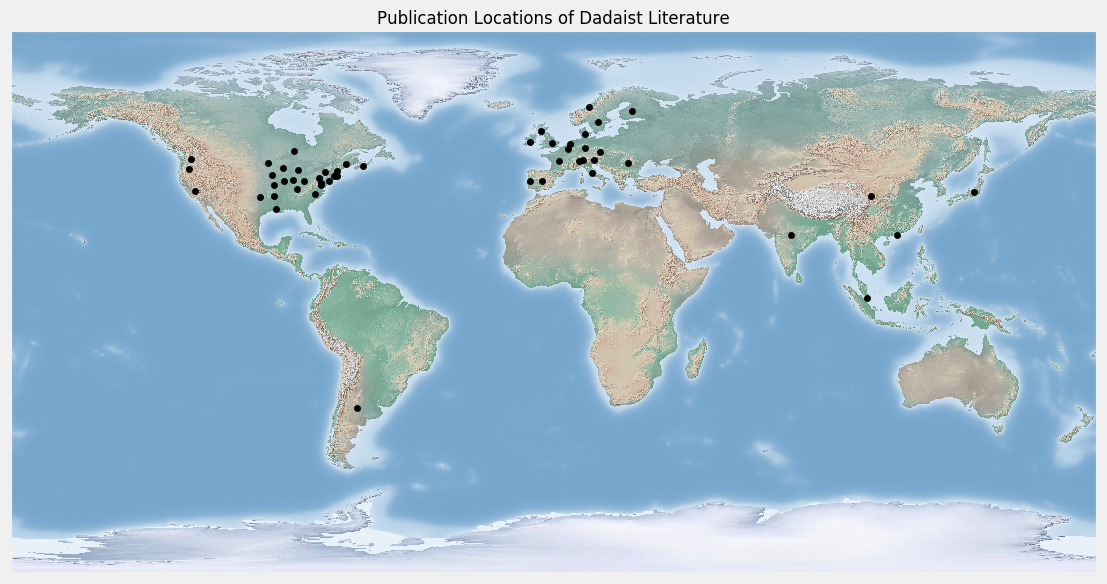

In [47]:
full_map = Basemap(projection='cyl', resolution=None)
full_map.shadedrelief()

fig = plt.gcf()
fig.set_size_inches(12.5, 8.5)

full_map.scatter(locations["Longitude"], locations["Latitude"], color="black")
plt.title("Publication Locations of Dadaist Literature", fontsize=12)

It seems, as expected, that the large majority of our collection's publication places are located in the United States or Europe. These are, arguably, the areas of the world most impacted by World War I.

# Some Descriptive Statistics

Firstly, how many unique locations exist in our collection?

In [48]:
len(locations) #Because each location has exactly one row in the table

53

We can quickly see now many times each location appears as a pub_place in our collection. Here are the top 5 (most frequent):

In [49]:
locations.sort_values("Count", ascending=False).head() #calling .head() will return the first 5 rows of a DataFrame

,Location Name,Abbreviation,Count,Latitude,Longitude
34,New York (State),nyu,373,43.156168,-75.844995
11,England,enk,100,52.795479,-0.540240
27,Massachusetts,mau,45,42.378877,-72.032366
15,Illinois,ilu,35,40.079632,-89.433981
13,France,fr,20,46.603354,1.888333


And here are the 5 least frequent:

In [50]:
locations.sort_values("Count", ascending=False).tail() #calling .tail() will return the last 5 rows of a DataFrame

,Location Name,Abbreviation,Count,Latitude,Longitude
29,Minnesota,mnu,1,45.989659,-94.611329
37,Nova Scotia,nsc,1,45.195587,-63.165894
30,Missouri,mou,1,38.760481,-92.561787
31,Netherlands,ne,1,52.237989,5.534607
0,Argentina,ag,1,-34.996496,-64.967282


How are the location counts distributed?

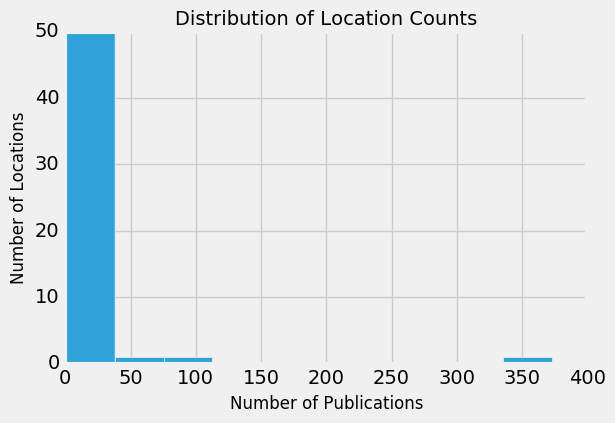

In [51]:
location_counts = locations["Count"]
plt.hist(location_counts)
plt.title("Distribution of Location Counts", fontsize=14)
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Number of Locations", fontsize=12)

This histogram should show the distribution of how many locations (y-axis) had a certain number of publications (x-axis).

It looks like there is a lot of spread between the highest count and second highest count; with 373 publications, New York has the highest number of publications published there, with England at a distant second at 100 publications. The publication counts from the other locations drop off signficantly after the top 5. Let's look at publication counts only between 0 and 30 to get a better picture of the distribution.

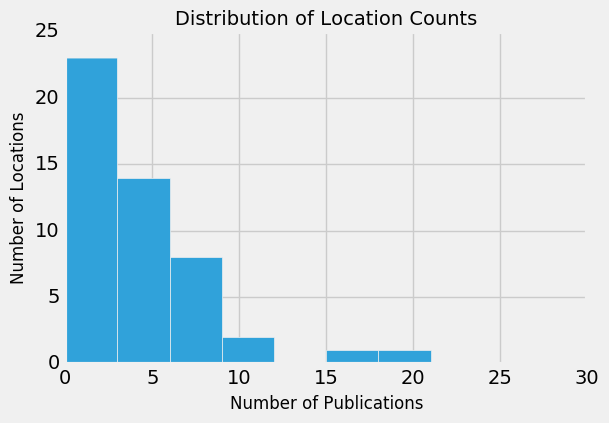

In [52]:
plt.hist(location_counts, range=(0, 30))
plt.title("Distribution of Location Counts", fontsize=14)
plt.xlabel("Number of Publications", fontsize=12)
plt.ylabel("Number of Locations", fontsize=12)

The majority of locations in our data seem to have produced less than 15 publications each.

How many of the locations are located in the United States?

In [53]:
# Reads in a file containing the names of the US states, (and Washington D.C)
with open('us_states.txt', 'r') as f:
    states = f.read()
    states = states.replace("\n", "")
states

'Alabama Alaska Arizona Arkansas California Colorado Connecticut Delaware District of Columbia Florida Georgia Hawaii Idaho Illinois Indiana Iowa Kansas Kentucky Louisiana Maine Maryland Massachusetts Michigan Minnesota Mississippi Missouri Montana Nebraska Nevada New Hampshire New Jersey New Mexico New York (State) North Carolina North Dakota Ohio Oklahoma Oregon Pennsylvania Rhode Island South Carolina South Dakota Tennessee Texas Utah Vermont Virginia Washington (State) West Virginia Wisconsin Wyoming '

In [54]:
# Determines whether a location is an American state
# We'll consider Washington D.C as a state for our purposes
def is_american_state(loc_name):
    state_string = loc_name.rstrip(" ") + " " #Every state_name has to have a whitespace after it
    
    return state_string in states #Is this location in the list of states? Returns True or False

In [55]:
#Appends a new column to the DataFrame 
locations["US State?"] = locations["Location Name"].apply(is_american_state)

In [56]:
np.count_nonzero(locations["US State?"] == True) #Counts the number of times that US State? is True

26

26 US states (including D.C) are represented in the data.

In [57]:
locations.sample(5) #Randomly samples 5 rows from the table

,Location Name,Abbreviation,Count,Latitude,Longitude,US State?
11,England,enk,100,52.795479,-0.540240,False
42,Pennsylvania,pau,7,40.969989,-77.727883,True
38,Ohio,ohu,5,40.225357,-82.688140,True
52,Wisconsin,wiu,8,44.430898,-89.688464,True
7,Connecticut,ctu,2,41.650020,-72.734216,True


Now, we can examine US states seperately by grouping the locations in our table. Let's start by seeing how much of our data is located in the US.

In [58]:
#Shows the raw counts of US and other countries' locations
locations.groupby("US State?")["Count"].sum()

US State?
False    201
True     543
Name: Count, dtype: int64

In [59]:
#Shows which fractions of the data are located in the US
locations.groupby("US State?")["Count"].sum() / locations["Count"].sum()

US State?
False    0.270161
True     0.729839
Name: Count, dtype: float64

It looks like nearly 3/4's of our data is located in the United States.

Let's divide our table into 2 parts, one that deals solely with US States and one that deals with other countries.

In [60]:
us_locations = locations[locations["US State?"] == True]
us_locations = us_locations.reset_index().drop("index", axis=1)
us_locations.sample(5)

,Location Name,Abbreviation,Count,Latitude,Longitude,US State?
16,New Jersey,nju,9,40.075738,-74.404162,True
20,Oklahoma,oku,4,34.955082,-97.268406,True
6,Iowa,iau,4,41.921673,-93.312270,True
23,Rhode Island,riu,1,41.796241,-71.599237,True
11,Massachusetts,mau,45,42.378877,-72.032366,True


In [61]:
rest_locations = locations[locations["US State?"] == False]
rest_locations = rest_locations.reset_index().drop("index", axis=1)
rest_locations.sample(5)

,Location Name,Abbreviation,Count,Latitude,Longitude,US State?
13,Italy,it,4,42.638426,12.674297,False
8,Finland,fi,2,63.246778,25.920916,False
11,India,ii,8,22.351115,78.667743,False
22,Scotland,stk,2,56.786111,-4.114052,False
24,Spain,sp,3,40.002803,-4.003104,False


# Locations in the United States

In [65]:
import matplotlib.cm
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import shapefile

Let's plot all the US locations in our collection. 

Firstly, we need to set our map boundaries. The tool I use to find boundary latitudes and longitudes for my graphs is [BoundingBox](http://boundingbox.klokantech.com/). Draw a box around the region you want to map, and the boundary coordinates will be displayed at the bottom of the screen. Select "Dublin Core" as the projection, as the coordinates are easier to interpret, and, for our purposes, the projection type won't matter too much. 

In [66]:
"""
Some Notes: 
--‘llcrnr’ stands for ‘lower left corner’ and ‘urcrnr’ stands for upper right corner.
--"The bounding coordinates I used were: westlimit=-128.94; southlimit=23.52; eastlimit=-60.12; northlimit=50.93
"""

# Creating an instance of a Basemap illustrating the contiguous US
us_locations_map = Basemap(resolution="l", llcrnrlon = -128.94,llcrnrlat =23.52 ,urcrnrlon =-60.12, 
                           urcrnrlat =50.93, lat_0 =37.26, lon_0 = -94.53)

In IPython, creating a [Basemap](https://matplotlib.org/basemap/users/geography.html) object is essentially displaying a map with the given settings and conditions, so, altering our map will require changes to attributes of this object. Because we haven't set it to display anything yet, the map is blank. Let's draw some basic features like continents.

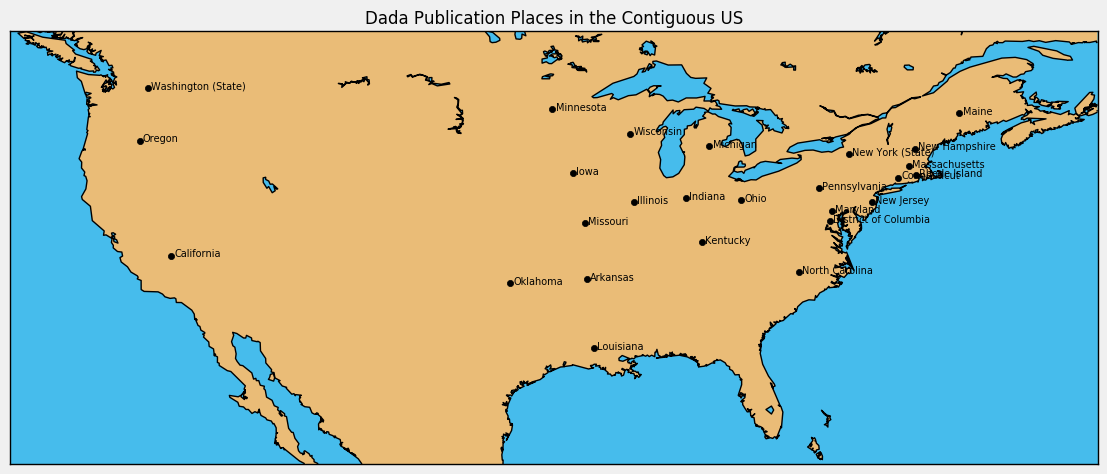

In [67]:
plt.title("Dada Publication Places in the Contiguous US", fontsize=12)

us_locations_map.drawmapboundary(fill_color = "#46bcec") #Fills in the oceans
us_locations_map.fillcontinents(color = "#eabc77", lake_color="#46bcec") #Defines the continents
us_locations_map.drawcoastlines()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12.5, 8.5) #Sets the size of the map

lons, lats = us_locations_map(us_locations["Longitude"], us_locations["Latitude"]) #Converts the coordinates to map points
us_locations_map.scatter(lons, lats, color ="black", zorder=10) #Draws the points on the map

#Labels each point with the location name
for i in range(0, us_locations.shape[0]):
    lat_lon = (us_locations["Longitude"][i] + .2, us_locations["Latitude"][i] -.1)
    plt.annotate(np.array(us_locations["Location Name"])[i], lat_lon, fontsize=7)

While it is informative to see how these locations are distributed geographically in the contiguous United States, we cannot yet see state boundaries. Let's overlay state borders over the current image and highlight the states in which at least one publication originated.

In [68]:
#Checks if a state is in our us_locations table
def us_locations_contains(string):
    for state in us_locations["Location Name"]:
        s_name = state.rstrip(" ")
        if s_name.endswith("(State)"):
            s_name = s_name.rstrip(" (State)")
        if s_name == string:
            return True
    return False

In [69]:
us_locations_contains("Washington")

True

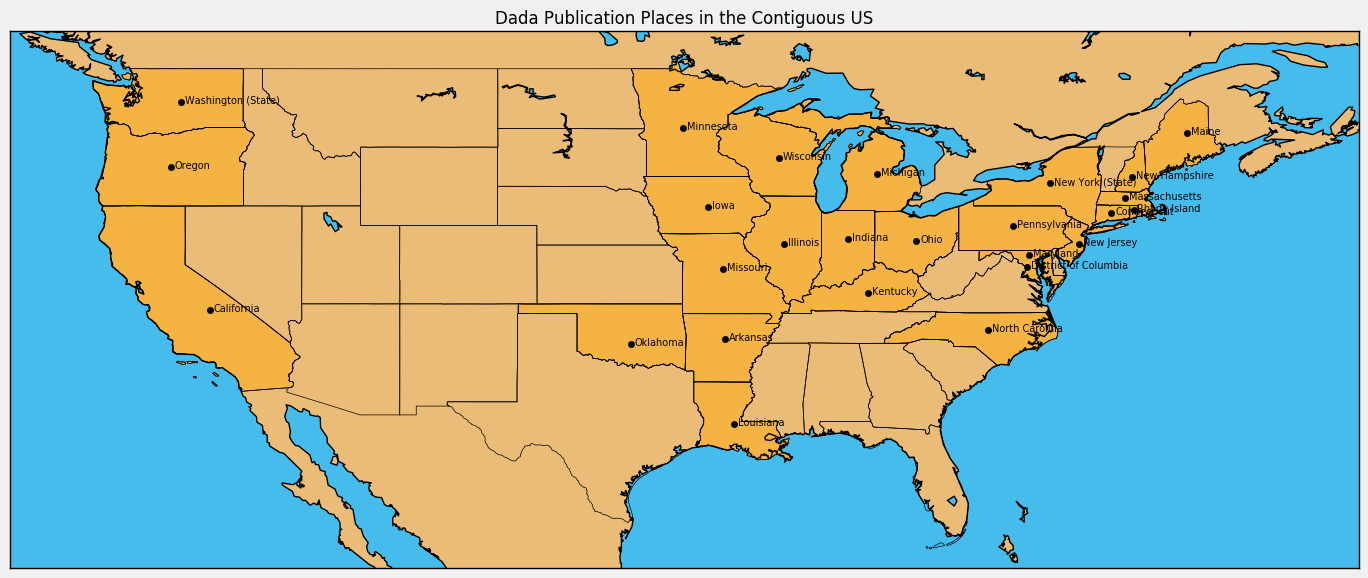

In [70]:
######################NOTE: NOT CHANGED#######################################################################
plt.title("Dada Publication Places in the Contiguous US", fontsize=12)

us_locations_map.drawmapboundary(fill_color = "#46bcec") #Fills in the oceans
us_locations_map.fillcontinents(color = "#eabc77", lake_color="#46bcec") #Defines the continents
us_locations_map.drawcoastlines()

lons, lats = us_locations_map(us_locations["Longitude"], us_locations["Latitude"]) #Converts the coordinates to map points
us_locations_map.scatter(lons, lats, color ="black", zorder=10) #Draws the points on the map

#Labels each point with the location name
for i in range(0, us_locations.shape[0]):
    lat_lon = (us_locations["Longitude"][i] + .2, us_locations["Latitude"][i] - .1)
    plt.annotate(np.array(us_locations["Location Name"])[i], lat_lon, fontsize=7)
###############################################################################################################

#Here we are reading in a shape file, which places state boundary information for our Basemap 
us_locations_map.readshapefile("us_shapefiles/cb_2016_us_state_20m", "us_states")

#Finding the state names from the shapefiles
state_names = []
for shape_dict in us_locations_map.us_states_info:
    state_names.append(shape_dict['NAME'])
    
ax = plt.gca() # get current axes instance

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 12.5) #Sets the size of the map

for index, state in enumerate(state_names):
    if us_locations_contains(state):
        seg = us_locations_map.us_states[index]
        poly = Polygon(seg, facecolor='#f4b342',edgecolor='black')
        ax.add_patch(poly)

While our present map shows which locations produced at least 1 Dada work from our collection, it does not yet convey how many  
publications originated from each state. A heat map might prove more useful in illustrating this.

In [71]:
#Helper function that finds the publication counts for each state

def find_count_by_state(state):
    if state == "New York" or state == "Washington":
        s_name = state + " (State)"
    else:
        s_name = state

    return us_locations[us_locations["Location Name"] == s_name].reset_index()["Count"][0]

In [72]:
find_count_by_state("Ohio")

5

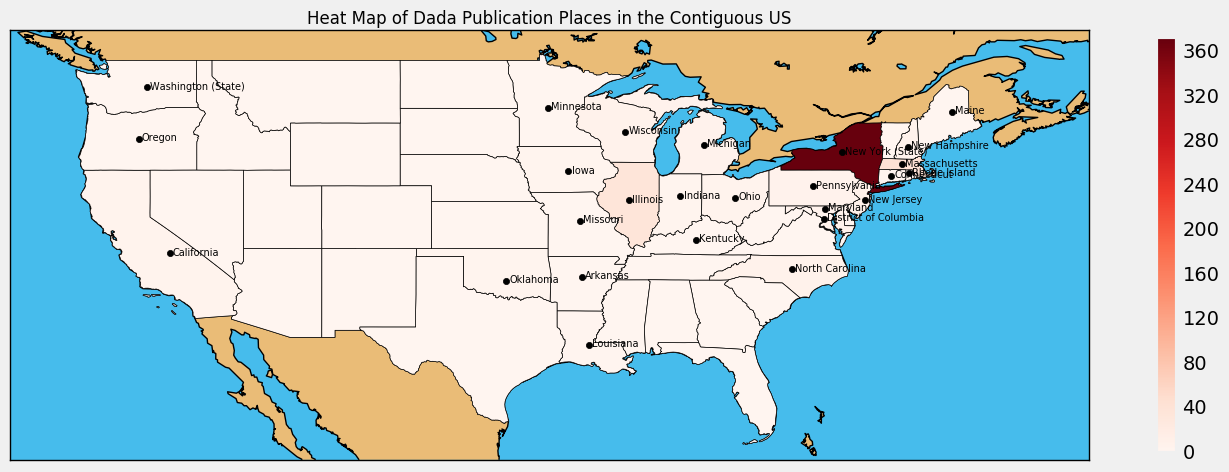

In [73]:
######################NOTE: NOT CHANGED#######################################################################
plt.title("Heat Map of Dada Publication Places in the Contiguous US", fontsize=12)

us_locations_map.drawmapboundary(fill_color = "#46bcec") #Fills in the oceans
us_locations_map.fillcontinents(color = "#eabc77", lake_color="#46bcec") #Defines the continents
us_locations_map.drawcoastlines()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 12.5) #Sets the size of the map

lons, lats = us_locations_map(us_locations["Longitude"], us_locations["Latitude"]) #Converts the coordinates to map points
us_locations_map.scatter(lons, lats, color ="black", zorder=10) #Draws the points on the map

#Labels each point with the location name
for i in range(0, us_locations.shape[0]):
    lat_lon = (us_locations["Longitude"][i] + .2, us_locations["Latitude"][i] - .1)
    plt.annotate(np.array(us_locations["Location Name"])[i], lat_lon, fontsize=7)

#Here we are reading in a shape file, which places state boundary information for our Basemap 
us_locations_map.readshapefile("us_shapefiles/cb_2016_us_state_20m", "us_states")

#Finding the state names from the shapefiles
state_names = []
for shape_dict in us_locations_map.us_states_info:
    state_names.append(shape_dict['NAME'])
###############################################################################################################
    
ax = plt.gca() # get current axes instance
cmap = plt.get_cmap('Reds')

names = []
shapes = []
counts = []

for index, state in enumerate(state_names):
    seg = us_locations_map.us_states[index]
    poly = Polygon(seg)
    names.append(state)
    shapes.append(poly)
    if us_locations_contains(state):
        counts.append(find_count_by_state(state))
    else:
        counts.append(0)

#Loading our lists into the DataFrame
shape_table = pd.DataFrame()
shape_table["State Name"] = np.array(names) 
shape_table["Shapes"] = np.array(shapes)
shape_table["Count"] = np.array(counts)

pc = PatchCollection(shape_table["Shapes"], zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(shape_table['Count'].fillna(0).values)))
pc.set_edgecolor("black")
ax.add_collection(pc)

#Adds colorbar showing the scale
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap) 
mapper.set_array(shape_table['Count'])
plt.colorbar(mapper, shrink=0.4)

It appears that New York has an extremely high concentration of Dada publications in our collection, which is largely indicative of its status as ["the primary center of Dada in the United States"](https://en.wikipedia.org/wiki/New_York_Dada). However, because the publication count from New York is a massive outlier skewing the scale of the heat map, it overshadows the display of other states we will have to omit it to get a more fine-grained analysis of the rest of the states.

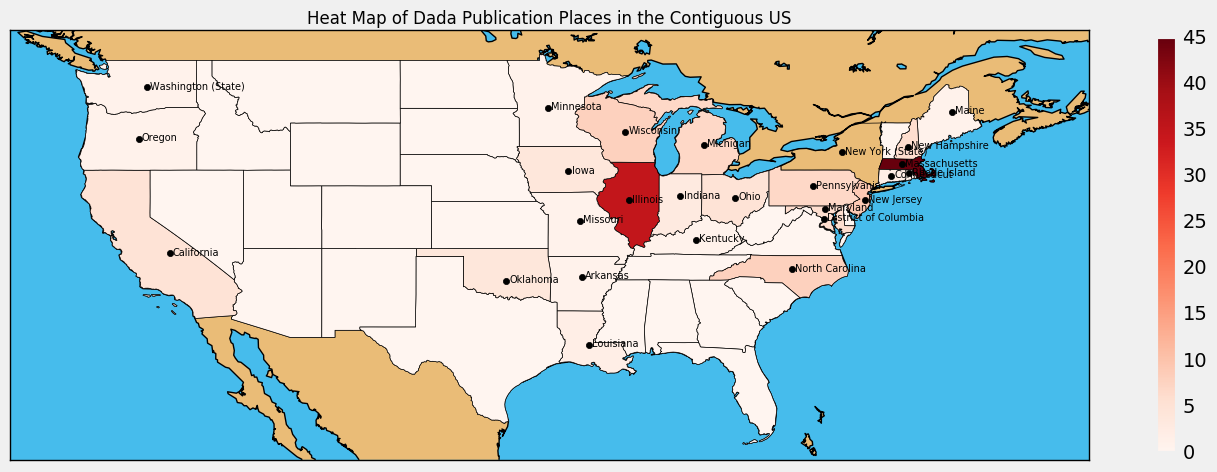

In [74]:
######################NOTE: NOT CHANGED#######################################################################
plt.title("Heat Map of Dada Publication Places in the Contiguous US", fontsize=12)

us_locations_map.drawmapboundary(fill_color = "#46bcec") #Fills in the oceans
us_locations_map.fillcontinents(color = "#eabc77", lake_color="#46bcec") #Defines the continents
us_locations_map.drawcoastlines()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 12.5) #Sets the size of the map

lons, lats = us_locations_map(us_locations["Longitude"], us_locations["Latitude"]) #Converts the coordinates to map points
us_locations_map.scatter(lons, lats, color ="black", zorder=10) #Draws the points on the map

#Labels each point with the location name
for i in range(0, us_locations.shape[0]):
    lat_lon = (us_locations["Longitude"][i] + .2, us_locations["Latitude"][i] - .1)
    plt.annotate(np.array(us_locations["Location Name"])[i], lat_lon, fontsize=7)
    
#Here we are reading in a shape file, which places state boundary information for our Basemap 
us_locations_map.readshapefile("us_shapefiles/cb_2016_us_state_20m", "us_states")
###############################################################################################################

ax = plt.gca() # get current axes instance
cmap = plt.get_cmap('Reds')

#Removing rows that deal with NY
reduced_shape_table = shape_table[shape_table["State Name"] != "New York"]

pc = PatchCollection(reduced_shape_table["Shapes"], zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(reduced_shape_table['Count'].fillna(0).values)))
pc.set_edgecolor("black")
ax.add_collection(pc)

#Adds colorbar showing the scale
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap) 
mapper.set_array(shape_table['Count'])
plt.colorbar(mapper, shrink=0.4)

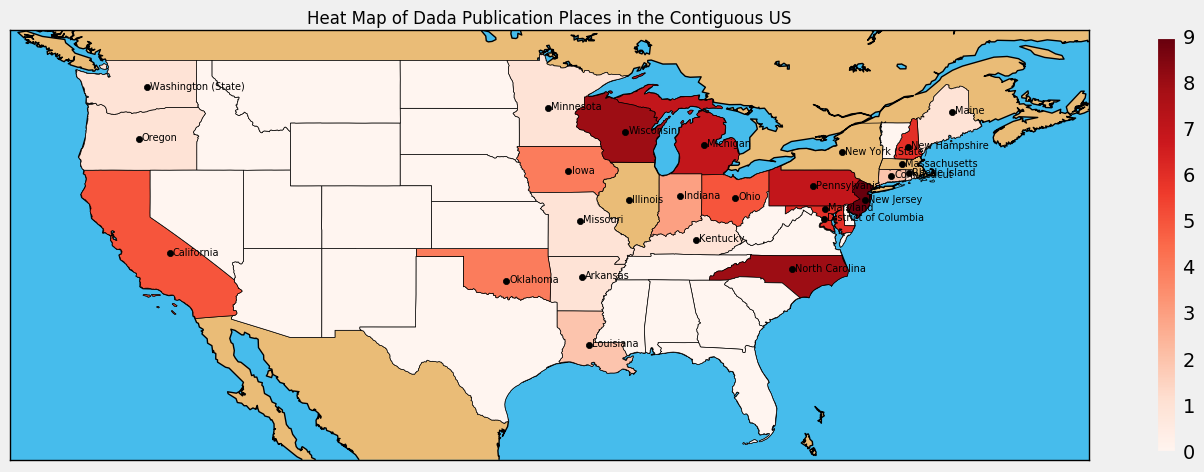

In [75]:
######################NOTE: NOT CHANGED#######################################################################
plt.title("Heat Map of Dada Publication Places in the Contiguous US", fontsize=12)

us_locations_map.drawmapboundary(fill_color = "#46bcec") #Fills in the oceans
us_locations_map.fillcontinents(color = "#eabc77", lake_color="#46bcec") #Defines the continents
us_locations_map.drawcoastlines()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15.5, 12.5) #Sets the size of the map

lons, lats = us_locations_map(us_locations["Longitude"], us_locations["Latitude"]) #Converts the coordinates to map points
us_locations_map.scatter(lons, lats, color ="black", zorder=10) #Draws the points on the map

#Labels each point with the location name
for i in range(0, us_locations.shape[0]):
    lat_lon = (us_locations["Longitude"][i] + .2, us_locations["Latitude"][i] - .1)
    plt.annotate(np.array(us_locations["Location Name"])[i], lat_lon, fontsize=7)
    
#Here we are reading in a shape file, which places state boundary information for our Basemap 
us_locations_map.readshapefile("us_shapefiles/cb_2016_us_state_20m", "us_states")
###############################################################################################################

ax = plt.gca() # get current axes instance
cmap = plt.get_cmap('Reds')

#Removing rows that deal with NY, Illinois, Massachusetts
reduced_shape_table = shape_table[shape_table["State Name"] != "New York"]
reduced_shape_table = reduced_shape_table[reduced_shape_table["State Name"] != "Illinois"]
reduced_shape_table = reduced_shape_table[reduced_shape_table["State Name"] != "Massachusetts"]

pc = PatchCollection(reduced_shape_table["Shapes"], zorder=2)
norm = Normalize()

pc.set_facecolor(cmap(norm(reduced_shape_table['Count'].fillna(0).values)))
pc.set_edgecolor("black")
ax.add_collection(pc)

#Adds colorbar showing the scale
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap) 
mapper.set_array(shape_table['Count'])
plt.colorbar(mapper, shrink=0.4)

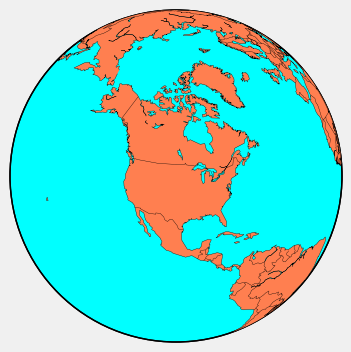

In [76]:
practice_map = Basemap(projection='ortho',lat_0=45,lon_0=-100,resolution='c')
practice_map.drawcoastlines(linewidth=0.25)
practice_map.drawcountries(linewidth=0.25)
practice_map.fillcontinents(color='coral',lake_color='aqua')

practice_map.drawmapboundary(fill_color='aqua')

## Credit

This highly-informative blog post: http://www.datadependence.com/2016/06/creating-map-visualisations-in-python/
        
This Stack-Overflow post: https://stackoverflow.com/questions/7586384/color-states-with-pythons-matplotlib-basemap